# Music Brain Project

*Can we guess how you will react to music?*


In the Spring of 2019, me (Ted Lewitt), Ben Hahn and Jack Elliott partnered with the Brain and Creativity Institute at USC to use deep learning methods to predict patients response to instrumental music.

### The Dataset

36 Patients went into a MRI and listened to 5 minute long instrumental songs that were either meant to be uplifting or sad. The MRI recorded their brain activations and the patients used a sliding scale to represent how they felt while listening to the music. 

![fd](Images/glass_brain.png "A sample MRI image")

### Our Hypothesis

We can use a recurrent nueral network to predict how a patient felt at a moment in time, based off the MRI data from that moment. 


In [1]:

import os
import nilearn
import numpy as np

import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Activation,Dense
from keras.layers.recurrent import LSTM

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Preprocessing

**Data Types** <br>

+ The MRI data file is known as fMRI and is stored in a NIFTI file (suffix .nii). It is a time series of MRI data, with each time step being a 3D volumetric snapshot of brain activations.

+ The slider data was a text file with timestamps and activations, on a scale of 0 to 127, with 127 being very happy and 0 being very sad.

### Preprocessing the Slider Data

**Initial Steps**

- The fMRI data was at 1 Hz but the slider data was at 30 Hz, so we had to down-sample the slider data to match the fMRI data.
- We scaled the slider data to be on a scale of (0,1) from (0,127).

- Human brains take an average of 6 seconds to process the music, so we need to add a 6 second delay between the slider data and the MRI image.

**Bucketing the Data & Switching from Regression to Classification** <br>

We were having issues with regressing the data (see our conculsions section for more info) so we decided to switch to a classsification problem using data bucketing.
![Bucket](Images/binning.png "An example of bucketing data")

Data bucketing transforms a continous variable (our slider data) into a discrete variable by taking all the continous data that lies in a certain area and lumping it all together in one bucket. In our example, all the continous slider data above 67.5 can be bucketed into the **Happy** bucket and all the data below 67.5 is bucketed into the **Sad** bucket. This allows us to use one hot encoding to represent the different classes, depending on how many buckets we decide to use.

In [2]:
NUM_BUCKETS = 4
DELAY = 6

def get_raw_slider_vals(data_file):
    data= load_slider_data(data_file)
    times = load_time_data(data_file)
    return times,data

def load_time_data(file):
    with open(file,'r') as fileobj:
        times = get_times(fileobj)
        times = np.array(times).astype(np.float)
        return times

def preprocess_slider_data(data_file):
    data = load_slider_data(data_file)
    label_array = down_sample(data, NUM_BUCKETS, DELAY)
    label_array = np.array(label_array)
    return label_array
  
def load_slider_data(file):
    with open(file,'r') as fileobj:
        values = get_vals(fileobj)
        values = np.array(values).astype(np.float)
        return values
def get_times(fobj):
    '''
    Read first line of text which contains the slider value
    '''
    indiv_lines = fobj.read().split("\n")
    values = []
    for i in range(len(indiv_lines)-1):
        values.append(indiv_lines[i].split("\t")[0])
    return values
def get_vals(fobj):
    '''
    Read second line of text which contains the slider value
    '''
    indiv_lines = fobj.read().split("\n")
    values = []
    for i in range(len(indiv_lines)-1):
        values.append(indiv_lines[i].split("\t")[1])
    return values

def down_sample(values, num_buckets, delay):
    '''
    Downsamples from 30Hz to 1Hz and Scales them from [0,127] to [0,1]
    Then creates a one hot encoding 
    '''
    maxValue = 127
    labels=[]
    for i in range(20,515-delay): 
        #Get the average of the 30 slider points each second
        sec_arr=np.array(values[30*i:30*i+29]).astype(np.float)
        #Scale the values to be between 0 and 1
        sec_avg=np.average(sec_arr)/maxValue
        #Create One Hot Encoding Vector
        one_hot = bucket(sec_avg, num_buckets)
    
        labels.append(one_hot)
        
    return labels

def bucket(value,num_buckets):
    '''
    Buckets the value into one of the #num_buckets
    '''
    #Create Empty Vector
    one_hot = [0]* num_buckets

    #Calculate which bucket the current datapoint should fit in
    index = int(np.floor(value*num_buckets))
    
    #Edge case of max value which would give out of bounds error
    if value == 1:
        index = num_buckets - 1
    
    #Update the vector
    one_hot[index] = 1
    
    return one_hot

**Let's Take a Look at One of the Files**

The first thing to notice is the first 20 seconds and last 5 seconds of the data are zeros and will skew the data, so we will discount them in the actual preprocessing.

The average for this run is 88, (and skewed by the zeros) so we can tell that is was likely a more happy piece of music.

Some descriptive statistics of the data:
Total Observations: 15446
Min: 0.0 
Max: 127.0
Average of the Data: 87.218503
Variance of the Data: 558.778475


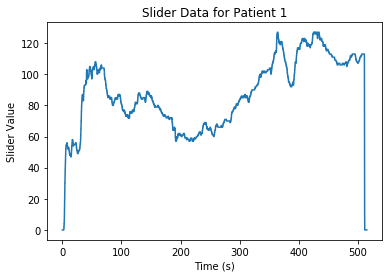

In [3]:
from scipy.stats import describe
import matplotlib.pyplot as plt
%matplotlib inline

filename = "txt_files/patient_01.txt"
times,data = get_raw_slider_vals(filename)

num_obs,min_max, mean,var,_,_ = describe(data)
print("Some descriptive statistics of the data:")
print("Total Observations: %d" % num_obs)
print("Min: %.1f \nMax: %.1f" % (min_max[0],min_max[1]))
print("Average of the Data: %f" % mean)
print("Variance of the Data: %f"% var)

plt.plot(times, data)
plt.title("Slider Data for Patient 1")
plt.xlabel("Time (s)")
plt.ylabel("Slider Value")
plt.show()

### Preprocessing the MRI Data
We used the niLearn package to transform our 4D fMRI (time steps, 3 spatial dimensions) to a 2D time series (time steps,
features). The initial shape of the input tensor was (495,100,90,100) and we wanted it to be (495, #Features) so it could be fed into our Tensorflow LSTM.

NiLearn has a class called NiftiMasker that does exactly that, transforming our data into an (495,29007) shaped time series. (This number of features is incedibly high we know, see our conclusions for more). <br>
![dg](Images/masking1.jpg "Illustration of Nifti Masker")


In [4]:
from nilearn.input_data import NiftiMasker
def create_time_series(mri_file):
    nifti_masker = NiftiMasker(standardize=True, mask_strategy='template')
    indexer = [i for i in range(0,495-DELAY)]
    #Split the fMRI data into 495 consecutive images
    result=nilearn.image.index_img(mri_file,indexer)
    nifti_masker.fit(result)
    masked=nifti_masker.transform(result)
    masked=np.array(masked)
    return masked


In [5]:
filename = "mri_files/patient_32.nii"

ts = create_time_series(filename)
print(ts.shape)

(489, 229007)


To keep track of which label data corresponded to which MRI data, the patients given an ID, so we load the data based on the ID.
This step does all the preprocessing and will take a long time.

In [6]:
from tqdm import tqdm
txt_files_dir = "txt_files/"
mri_files_dir = "mri_files/"
nii_array = []
label_array = []
for count in tqdm(range(1,40)):
    if count<10:
        count = str(0)+str(count)
        
    niifile = "patient_"+str(count)+".nii"
    fullNii = os.path.join(mri_files_dir,niifile)
    
    labelfile = "patient_"+str(count)+".txt"
    fullfile = os.path.join(txt_files_dir,labelfile)

    try:
        ts = create_time_series(fullNii)        
        label = preprocess_slider_data(fullfile)
        nii_array.append(ts)
        label_array.append(label)
    except ValueError:
        print("Incomplete Data for Patient %s" % count)
                         

nii_array=np.array(nii_array)
label_array=np.array(label_array)

assert(len(nii_array) == len(label_array))

 15%|█▌        | 6/39 [02:02<11:16, 20.51s/it]

Incomplete Data for Patient 07


 44%|████▎     | 17/39 [05:14<06:36, 18.03s/it]

Incomplete Data for Patient 18


 69%|██████▉   | 27/39 [07:55<03:33, 17.77s/it]

Incomplete Data for Patient 28


 74%|███████▍  | 29/39 [08:13<02:31, 15.12s/it]

Incomplete Data for Patient 30


100%|██████████| 39/39 [10:54<00:00, 16.78s/it]


### Hyperparameters

These are the optimal hyperparameters we found for our model.
See PostProcessing for an discussion on other hyperparameters we explored for our model

In [10]:
nii_shape = nii_array[0].shape
EPOCHS = 4
BATCH_SIZE = 5
if NUM_BUCKETS == 2: 
    LOSS = 'binary_cross_entropy'
    METRICS = [metrics.binary_accuracy]
else:
    LOSS = 'categorical_crossentropy'
    METRICS = [metrics.categorical_accuracy]
OPTIMIZER = 'Adam'
INPUT_SHAPE = nii_shape
DROPOUT = .15

In [11]:
totalFiles=len(label_array)
nii_shape = nii_array[0].shape
# Split the Data Into A Train and Test Subsets 
train_labels, test_labels, train_nii, test_nii = train_test_split(label_array, nii_array)

train_labels = np.array(train_labels)
train_nii = np.array(train_nii)
test_labels = np.array(test_labels)
test_nii = np.array(test_nii)

print(train_labels.shape)
print(train_nii.shape)

(26, 489, 4)
(26, 489, 229007)


## Training

We decided to use the Keras implementation of the Long Short-Term Memory RNN becuase of the time series nature of the data. Also the human brain has the memory of the whole song when forming emotions, so we needed a model that also had this capability. The strength of the LSTM to capture both short term trends and keep a longer memory suited our needs well.

To predict a bucket over all 495 time steps at the same time we added the TimeDistributed Dense Layer. This means the model's output was a (495,NUM_BUCKETS) matrix with one hot encoding of the predicted bucket.

![LSTM_DIAGRAM](Images/lstm_diagram.png "Model Diagram")

In [12]:
#Model Initilization
model=Sequential()

model.add(LSTM(units=nii_shape[0], activation='tanh', dropout=DROPOUT, input_shape=INPUT_SHAPE, return_sequences=True))

model.add(keras.layers.TimeDistributed(Dense(NUM_BUCKETS,activation='softmax')))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 489, 489)          448896132 
_________________________________________________________________
time_distributed_1 (TimeDist (None, 489, 4)            1960      
Total params: 448,898,092
Trainable params: 448,898,092
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
## Training
EPOCHS = 1
model.compile(loss=LOSS,optimizer=OPTIMIZER, metrics=METRICS)

model.fit(train_nii,train_labels,epochs=EPOCHS,batch_size=BATCH_SIZE)

Epoch 1/1
26/26 [==============================] - ETA: 2:26:53 - loss: 1.4678 - categorical_accuracy: 0.255 - ETA: 1:49:55 - loss: 2.7407 - categorical_accuracy: 0.233 - ETA: 1:13:57 - loss: 3.1795 - categorical_accuracy: 0.217 - ETA: 39:36 - loss: 2.9664 - categorical_accuracy: 0.2491  - ETA: 6:28 - loss: 2.8527 - categorical_accuracy: 0.256 - 12756s 491s/step - loss: 2.8555 - categorical_accuracy: 0.2502


In [16]:
#Evaulation
score = model.evaluate(test_nii,test_labels,verbose=1, batch_size=4)
print(score)

9/9 [==============================] - ETA: 54 - ETA: 10 - 121s 13s/step
sucess
[2.090882592731052, 0.2172233611345291]


### HyperParameter Tuning

To find optimal hyperparameters, we used a naive grid search method, combining all of the following options:

**Epochs**- [4,8,12,16] <br>
**Batch Size** - [5,10] <br>
**Dropout** - [.08,.15,.25,.40] <br>
**Number of Buckets**- [2,4,10] <br>

The optimal combination we found is: <br>
**Epochs**: 4 <br>
**Batch Size**: 5 <br>
**Dropout**: .15 <br>
**Number of Buckets**: 2 <br> 

We found the model has major issues overfitting, so less epochs performed better.

We also found less buckets made the model more accurate, which intiutively makes sense becuase it has a much larger range of error with one bucket instead of two.

### Best Results
+ 88% Accuracy with 2 Buckets
+ 32% Accuracy with 4 Buckets



# Conclusion

Our project was a failure. We didnt achieve high accuracy and it doesn't seem like our model learned anything about the human brain. That doesn't mean that we did not learn a lot. Analyzing why it didn't work has been a huge learning experience for us and will help us on future projects. Here is an non-exasutive list of things that went wrong.

+ **Lack of Domain Knowledge in Preprocessing:** We had no domain knowledge in the field of fMRI, so we blindly used the niLearn preprocessing with little understanding of the methods behind it.
<br><br>
+ **Too Many Features and Too Little Data:** Our feature space was over 250,000 features, far too many for any predictive model, even with an massive dataset. Our model could never hope to accurately use them all and suffered accordingly. Even if we could have reduced the feature space, we still only had 17,325 (495 seconds X 35 people) instances in our full dataset. 
<br><br>
+ **Oversimplification of the Human Brain:** Even if we had an incredibly powerful model, human brains are intricate and work in complex ways so trying to model it this way makes a lot of assumption. At the time of writing this, the most accurate paper (Bandettini et al)[https://www.sciencedirect.com/science/article/abs/pii/S1053811918320263] we could find has 50% accuracy with 4 buckets, showing how even the state of the art methods still struggle with modeling the human brain.



## Future Steps

+ **Try a CNN_LSTM** Instead of using niLearn to preprocess our data, feed the MRI data directly into a 3D Convolutional Neural Network and pass it's output into the LSTM. This will be much more challenging to train and our dataset is far too small, but could see some improvements due to the CNN's ability to capture spatial features.

+ **Reduce the Feature Space using ROIs** Try only using certain parts of the brain (Regions of Interest) that are known to strongly correlate to music and or emotion to reduce the feature space to a subsection of the brain. 
